<a href="https://colab.research.google.com/github/LeonVillanueva/CoLab/blob/master/Google_CoLab_LSTM_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [0]:
!pip install -q tensorflow==2.0.0-beta1

In [0]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [0]:
import math
import seaborn as sns

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, GaussianNoise, BatchNormalization, MaxPooling2D, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
from scipy import stats

### Loading & Transform Data

In [0]:
mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
site = 'https://raw.githubusercontent.com/LeonVillanueva/CoLab/master/Data/RUT.csv'
df = pd.read_csv (site, header=0, parse_dates=['Date'], date_parser=mydateparser)

In [0]:
df['Diff'] = (df['Close'] / df['Close'].shift(1) - 1) * 100
df['Diff'] = df['Diff'].shift(-1)

In [0]:
df['Max_30'] = df['Close'].rolling(window=30).max()
df['Min_30'] = df['Close'].rolling(window=30).min()
df['Ave_30'] = df['Close'].rolling(window=30).mean()

# df['Vol_Adj'] = df['Volume']
# df['Close_Adj'] = df['Close']

> ***Explanation: Shifted everything by 1, since all information is from t-1 days and prior.***

In [0]:
# df['Date'].shift(-1)[:10]

In [138]:
df[30:35]

,Date,Open,High,Low,Close,Adj Close,Volume,Diff,Max_30,Min_30,Ave_30
30,1987-10-22,130.649994,130.649994,124.470001,124.570000,124.570000,3922000,-2.392232,172.539993,121.389999,162.263666
31,1987-10-23,124.580002,124.580002,121.360001,121.589996,121.589996,2456000,-9.260625,172.539993,121.389999,160.631999
32,1987-10-26,121.580002,121.580002,110.320000,110.330002,110.330002,3088000,-1.649597,172.539993,110.330002,158.628666
33,1987-10-27,110.320000,113.120003,108.370003,108.510002,108.510002,2602000,-2.239425,172.539993,108.510002,156.605666
34,1987-10-28,105.459999,108.500000,105.459999,106.080002,106.080002,2794000,4.449473,172.539993,106.080002,154.511000


In [0]:
final = df[['Date','Open','High','Low','Max_30','Min_30','Ave_30', 'Volume','Close','Diff']]

In [0]:
final = final.dropna ()

In [0]:
X = final[['Open','High','Low','Max_30','Min_30','Ave_30', 'Volume','Close']].values

In [0]:
scaler = StandardScaler()

In [0]:
# X = scaler.fit_transform (X)
# have to run only fit on X_train then transform both X_train, X_test -> otherwise data leakage

In [0]:
D = len (X[0])

In [0]:
# X = np.asarray (X).reshape (-1, T, 1)

In [0]:
y = final['Diff'].values

In [147]:
X.shape, y.shape

((8129, 8), (8129,))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=23)

In [0]:
scaler.fit (X_train)

X_train = scaler.transform (X_train)
X_test = scaler.transform (X_test)

In [0]:
look_back = 10

> https://github.com/Tony607/Keras_TimeseriesGenerator/blob/master/TimeseriesGenerator.ipynb

> https://www.dlology.com/blog/how-to-use-keras-timeseriesgenerator-for-time-series-data/?t=158023255417#rating-54

In [0]:
time = TimeseriesGenerator (X_train,
                            y_train,
                            length=look_back,
                            sampling_rate=1,
                            stride=1,
                            batch_size=3)

### Model Building

In [0]:
i = Input (shape=(look_back, D))
x = LSTM (120) (i)
x = Dense (10) (x)
x = Dropout (0.5) (x)
x = Dense (1) (x)

In [0]:
model = Model (i, x)

In [0]:
adam = tf.keras.optimizers.Adam (learning_rate=0.01, decay=5e-5)

In [0]:
model.compile (optimizer=adam,
               loss='mse')

In [0]:
epochs = 100

In [0]:
r = model.fit_generator (time, epochs=epochs, verbose=False)

In [0]:
time_hat = TimeseriesGenerator (X_test,
                                y_test,
                                length=look_back,
                                sampling_rate=1,
                                stride=1,
                                batch_size=3)

In [159]:
model.evaluate_generator (time_hat)

2.366029261478356

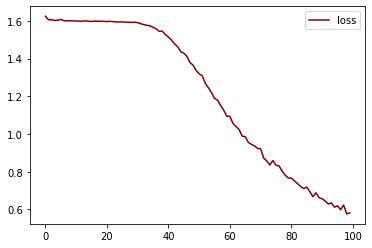

In [160]:
plt.plot (r.history['loss'], label='loss', color='#840000')
plt.legend ()

In [0]:
y_hat = model.predict_generator (time_hat)

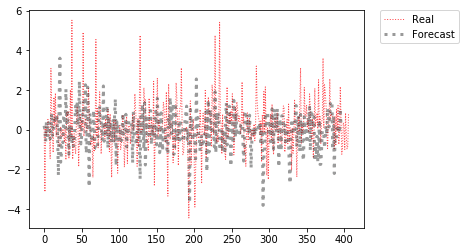

In [162]:
plt.plot(y_test, color='#ff474c', label='Real', linewidth=1, linestyle=':')
plt.plot(y_hat, color='#363737', label='Forecast', linewidth=3, linestyle=':', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [163]:
model.predict(X_train [-10:].reshape (-1, look_back, D))

array([[-0.4332572]], dtype=float32)

In [164]:
y_train [-1:]

array([0.20288613])

### **Inquiry and conclusion : How can you predict volume? Using this model for anything outside of a T+1 would be folly**